In [ ]:
# To group the endgame data into comps based on synergies and champions used
# Attempt to use HAC 

In [ ]:
# Useful links
# https://www.notion.so/Introduction-to-Git-ac396a0697704709a12b6a0e545db049
# https://www.notion.so/Introduction-to-GitHub-202af6f64bbd4299b15f238dcd09d2a7
# https://developer.riotgames.com/
# https://developer.riotgames.com/apis#tft-match-v1/GET_getMatch
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [214]:
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt


In [4]:
with open('match_data/match_data_challenger_euw_10.11_300520.txt') as json_file:
    match_data_json = json.load(json_file)

In [119]:
# Modelling each participant's traits as sets
def get_traits_set(participant: dict):
    traits_list = participant['traits']
    traits = []
    for i in traits_list:
        for j in range(i['tier_current']):
            traits.append(i['name'] + '_' + str(j+1))            
    return set(traits)


traits_data = []
for i in match_data_json:
    for j in i['info']['participants']:
        traits_data.append(get_traits_set(j))

traits_count_dict = {}
for i in traits_data:
    i_str = ' '.join(i)
    traits_count_dict[i_str] = traits_count_dict.get(i_str, 0) + 1

traits_count_list = [[k,v] for k, v in sorted(traits_count_dict.items(), key=lambda item: item[1], reverse=True)]

#traits_count_list[0:100]

In [78]:
def similarity(a: set, b: set):
    return len(a.intersection(b))/len(a.union(b))

In [84]:
def abs_distance(a: set, b: set):
    return len(a.symmetric_difference(b))

In [149]:
# Modelling each participant's traits as vectors
with open('set3/traits.json') as json_file:
    ref_traits_json = json.load(json_file)

ref_traits_index_dict = {ref_traits_json[i]['key']:i for i in range(len(ref_traits_json))}

def get_traits_as_vector(participant: dict):
    traits_list = participant['traits']
    traits = np.zeros(23)
    for i in traits_list:
        if i['name'] != 'TemplateTrait':
            traits[ref_traits_index_dict[i['name']]] = i['tier_current']
    return traits

traits_data_vectors = []
for i in match_data_json:
    for j in i['info']['participants']:
        traits_data_vectors.append(get_traits_as_vector(j))
traits_data_vectors = np.array(traits_data_vectors)


In [413]:
len(traits_data_vectors)

3056

In [173]:
def traits_vector_totext(v, rounding=1):
    v = np.round(v,1)
    trait_names = list(ref_traits_index_dict.keys())
    v_text = []
    for i in range(len(v)):
        if v[i] > 0:
            v_text.append(trait_names[i]+'_'+str(v[i]))
    return v_text

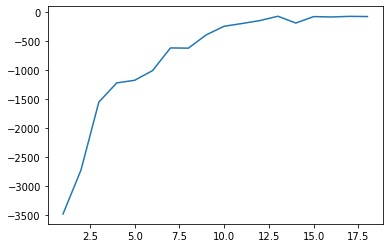

In [365]:
# 
kmeans_ss = []
for i in range(1, 20):
    kmeans = sklearn.cluster.KMeans(n_clusters=i).fit(traits_data_vectors)
    kmeans_ss.append(kmeans.inertia_)

kmeans_ss_diff = [kmeans_ss[i+1]-kmeans_ss[i] for i in range(len(kmeans_ss)-1)]
plt.plot(range(1, 19), kmeans_ss_diff)

kmeans = sklearn.cluster.KMeans(n_clusters=15).fit(traits_data_vectors)

#list(map(traits_vector_to_text, kmeans.cluster_centers_))

In [314]:
clustering = sklearn.cluster.AgglomerativeClustering(affinity='l1', linkage='average').fit(traits_data_vectors)

In [258]:
len(traits_data_vectors)

3056

In [261]:
clustering.children_[0:10]

array([[   0,  188],
       [   1,   24],
       [   2,   78],
       [1734, 2362],
       [  44, 2674],
       [ 399, 2279],
       [ 473, 1134],
       [2231, 3062],
       [3013, 3063],
       [  29,  258]])

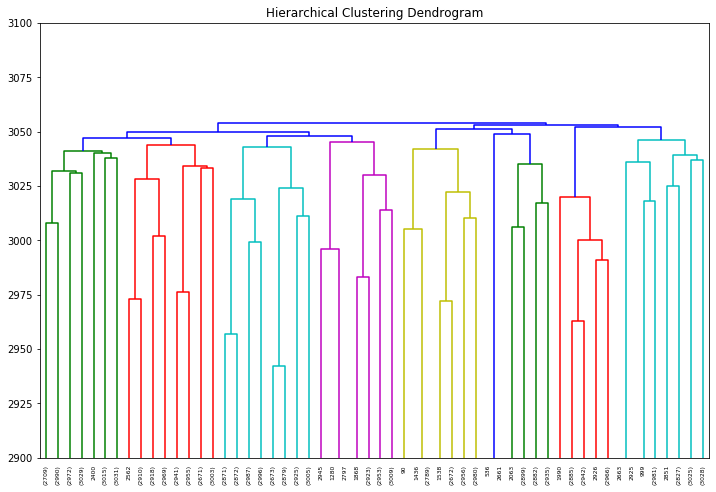

In [254]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(12,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, truncate_mode='level', p=5, color_threshold=3047)
plt.ylim(2900, 3100)
plt.show()

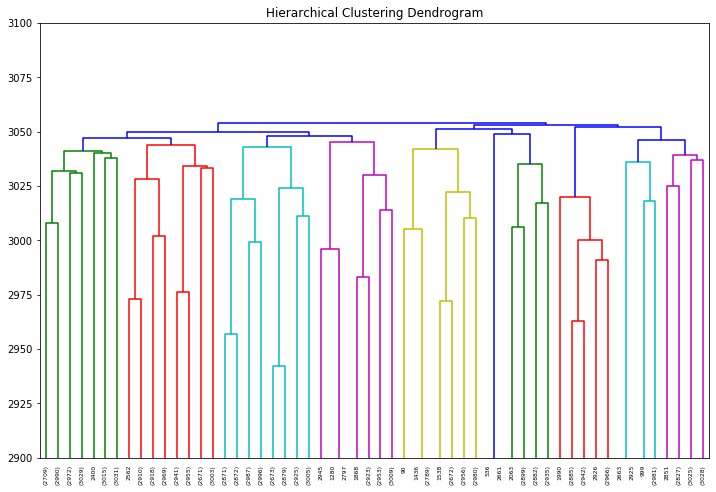

In [417]:
clustering = sklearn.cluster.AgglomerativeClustering(affinity='l1', linkage='average').fit(traits_data_vectors)

plt.figure(figsize=(12,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, truncate_mode='level', p=5, color_threshold=3046)
plt.ylim(2900, 3100)
plt.show()

In [403]:
clustering.labels_

array([0, 0, 0, ..., 1, 1, 0])

In [312]:
def HCA_label_matrix(model):
    children = model.children_
    n = model.n_leaves_
    label_matrix = np.zeros((n, n))
    label_matrix[0] = np.arange(n)
    for i in range(1,n):
        label_matrix[i] = label_matrix[i-1]
        merging_clusters = children[i-1]
        for j in range(n):
            if label_matrix[i][j] == merging_clusters[0] or label_matrix[i][j] == merging_clusters[1]:
                label_matrix[i][j] = i+n-1
    return label_matrix

In [315]:
a = HCA_label_matrix(clustering)

In [320]:
a[1000]

array([3056., 3652., 3768., ..., 3053., 3054., 3055.])

In [401]:
from sklearn import metrics

n_range = 30
n_clusters = range(2,n_range+1)
n_silhouette_score = []
for i in n_clusters:
    n_silhouette_score.append(metrics.silhouette_score(traits_data_vectors, a[len(a)-i], metric='l1'))

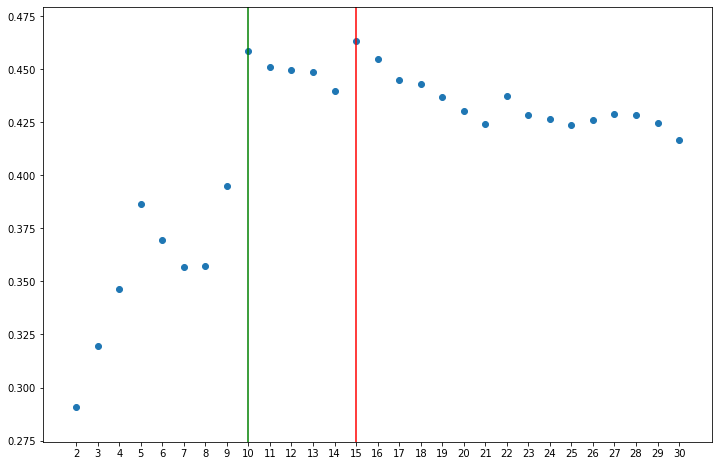

In [414]:
plt.figure(figsize=(12,8))
plt.xticks(range(2, n_range+1))
plt.scatter(n_clusters, n_silhouette_score)
plt.axvline(x=n_clusters[n_silhouette_score.index(max(n_silhouette_score))], color='r')
plt.axvline(x=10, color='g')

In [419]:
set(a[3056-10])

{5911.0,
 6076.0,
 6091.0,
 6092.0,
 6095.0,
 6097.0,
 6098.0,
 6099.0,
 6100.0,
 6101.0}